## Benchmark model

### Train, test and validation split

IBM Stock train, test and validation split

In [59]:
train_size = int(len(df_ibm) * 0.90)
test_size = int(len(df_ibm) * 0.08)
valid_size = len(df_ibm) - (train_size + test_size)
df_ibm_train, df_ibm_test, df_ibm_valid = df_ibm[0:train_size].copy(),\
                                            df_ibm[train_size:train_size+test_size].copy(),\
                                            df_ibm[train_size+test_size:len(df_ibm)].copy()
print(len(df_ibm), len(df_ibm_train), len(df_ibm_test), len(df_ibm_valid))

14889 13400 1191 298


In [60]:
assert(len(df_ibm) == (len(df_ibm_train) + len(df_ibm_test) + len(df_ibm_valid)))

Amazon Stock train test split

In [61]:
train_size = int(len(df_amzn) * 0.90)
test_size = int(len(df_amzn) * 0.08)
valid_size = len(df_amzn) - (train_size + test_size)
df_amzn_train, df_amzn_test, df_amzn_valid = df_amzn[0:train_size].copy(),\
                                            df_amzn[train_size:train_size+test_size].copy(),\
                                            df_amzn[train_size+test_size:len(df_amzn)].copy()
print(len(df_amzn), len(df_amzn_train), len(df_amzn_test), len(df_amzn_valid))

5984 5385 478 121


In [62]:
assert(len(df_amzn) == (len(df_amzn_train) + len(df_amzn_test) + len(df_amzn_valid)))

Apple Inc. Stock train test split

In [63]:
train_size = int(len(df_aapl) * 0.90)
test_size = int(len(df_aapl) * 0.08)
valid_size = len(df_aapl) - (train_size + test_size)
df_aapl_train, df_aapl_test, df_aapl_valid = df_aapl[0:train_size].copy(),\
                                            df_aapl[train_size:train_size+test_size].copy(),\
                                            df_aapl[train_size+test_size:len(df_aapl)].copy()
print(len(df_aapl), len(df_aapl_train), len(df_aapl_test), len(df_aapl_valid))

10135 9121 810 204


Alphabet Inc. Stock train test split

In [64]:
train_size = int(len(df_googl) * 0.90)
test_size = int(len(df_googl) * 0.08)
valid_size = len(df_googl) - (train_size + test_size)
df_googl_train, df_googl_test, df_googl_valid = df_googl[0:train_size].copy(),\
                                            df_googl[train_size:train_size+test_size].copy(),\
                                            df_googl[train_size+test_size:len(df_googl)].copy()
print(len(df_googl), len(df_googl_train), len(df_googl_test), len(df_googl_valid))

4158 3742 332 84


#### Simple Moving Average (SMA)

Moving average is a techical indicator that smooths real data oscillations over time.
It can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.

In this notebook, I'll use Simple Moving Average indicator as a benchmark model.
In order to do this, I will compute it separately on training data and test data, to avoid leakage.

SMA will be used in the project for three purposes:
* Detect if some seasonal pattern is present in data
* A benchmark for deep learning model performance
* An additional feature to be used to train deep learning model

Before moving to feature engineering, reference date index to be used to build the model will be defined:

In [65]:
analysis_start_date = '2010-01-1'

Anyway, new feature will be computed on the whole dataframe. Plotting will be limited to `analysis_start_date`

In [75]:
from ta_utils.technical_indicators import moving_average, volatility

#### IBM stock moving averages

In [76]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))
    df_ibm[column_name] = moving_average(df_ibm['Adj Close'], window_size=mds)
    df_ibm_train[column_name] = moving_average(df_ibm_train['Adj Close'], window_size=mds)
    df_ibm_test[column_name] = moving_average(df_ibm_test['Adj Close'], window_size=mds)
    df_ibm_valid[column_name] = moving_average(df_ibm_valid['Adj Close'], window_size=mds)

In [77]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [78]:
df_ibm.fillna(method='backfill', inplace=True)

In [79]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152


In [80]:
df_ibm_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


In [81]:
df_ibm_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2015-03-27,160.789993,160.899994,159.229996,160.399994,124.163673,3477900,NaN,NaN,NaN
2015-03-30,161.309998,163.600006,161.250000,162.669998,125.920868,4138000,NaN,NaN,NaN
2015-03-31,161.080002,162.330002,160.399994,160.500000,124.241081,4255400,NaN,NaN,NaN
2015-04-01,160.229996,160.619995,158.389999,159.179993,123.219307,3700800,NaN,NaN,NaN
2015-04-02,159.520004,162.539993,158.889999,160.449997,124.202393,4671600,NaN,NaN,NaN


In [82]:
df_ibm_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-12-18,134.550003,135.000000,134.149994,134.410004,126.028175,3101800,NaN,NaN,NaN
2019-12-19,134.460007,134.729996,134.190002,134.559998,126.168839,3866500,NaN,NaN,NaN
2019-12-20,135.740005,136.419998,134.949997,135.589996,127.134598,7111800,NaN,NaN,NaN
2019-12-23,135.779999,136.149994,135.000000,135.550003,127.097092,2803200,NaN,NaN,NaN
2019-12-24,135.610001,135.619995,134.610001,134.979996,126.562637,1202100,NaN,NaN,NaN


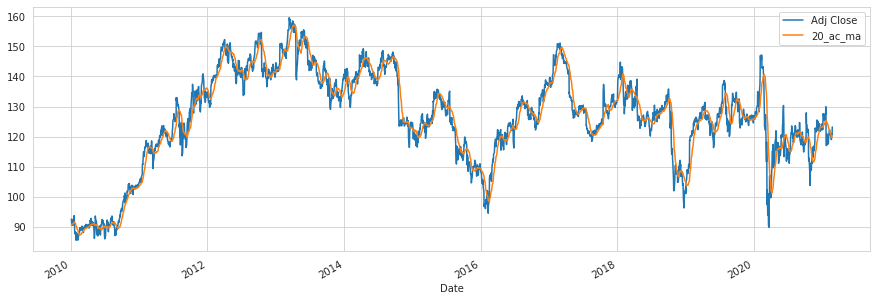

In [83]:
df_ibm[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

#### Apple stock moving averages

#### Apple stock moving averages

In [84]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_aapl[column_name] = moving_average(df_aapl['Adj Close'], window_size=mds)
    df_aapl_train[column_name] = moving_average(df_aapl_train['Adj Close'], window_size=mds)
    df_aapl_test[column_name] = moving_average(df_aapl_test['Adj Close'], window_size=mds)
    df_aapl_valid[column_name] = moving_average(df_aapl_valid['Adj Close'], window_size=mds)

In [85]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [86]:
df_aapl.fillna(method='backfill', inplace=True)

In [87]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248


In [88]:
df_aapl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


In [89]:
df_aapl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2017-02-14,33.367500,33.772499,33.312500,33.755001,32.059544,132904800,NaN,NaN,NaN
2017-02-15,33.880001,34.067501,33.654999,33.877499,32.175884,142492400,NaN,NaN,NaN
2017-02-16,33.917500,33.974998,33.709999,33.837502,32.137894,90338400,NaN,NaN,NaN
2017-02-17,33.775002,33.957500,33.775002,33.930000,32.225754,88792800,NaN,NaN,NaN
2017-02-21,34.057499,34.187500,33.994999,34.174999,32.458447,98028800,NaN,NaN,NaN


In [90]:
df_aapl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-05-05,73.764999,75.250000,73.614998,74.389999,73.817802,147751200,NaN,NaN,NaN
2020-05-06,75.114998,75.809998,74.717499,75.157501,74.579391,142333600,NaN,NaN,NaN
2020-05-07,75.805000,76.292503,75.492500,75.934998,75.350914,115215200,NaN,NaN,NaN
2020-05-08,76.410004,77.587502,76.072502,77.532501,77.144394,134048000,NaN,NaN,NaN
2020-05-11,77.025002,79.262497,76.809998,78.752502,78.358284,145946400,NaN,NaN,NaN


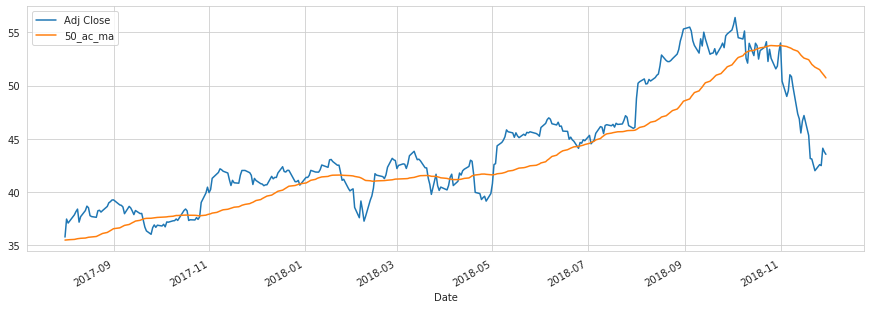

In [91]:
df_aapl[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

#### Amazon.com stock moving averages

In [92]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_amzn[column_name] = moving_average(df_amzn['Adj Close'], window_size=mds)
    df_amzn_train[column_name] = moving_average(df_amzn_train['Adj Close'], window_size=mds)
    df_amzn_test[column_name] = moving_average(df_amzn_test['Adj Close'], window_size=mds)
    df_amzn_valid[column_name] = moving_average(df_amzn_valid['Adj Close'], window_size=mds)

In [93]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [94]:
df_amzn.fillna(method='backfill', inplace=True)

In [95]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813


In [96]:
df_amzn_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


In [97]:
df_amzn_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,NaN,NaN,NaN
2018-10-09,1859.989990,1896.680054,1852.319946,1870.319946,1870.319946,4772900,NaN,NaN,NaN
2018-10-10,1857.890015,1858.560059,1754.410034,1755.250000,1755.250000,10988900,NaN,NaN,NaN
2018-10-11,1724.000000,1755.400024,1685.099976,1719.359985,1719.359985,13935900,NaN,NaN,NaN
2018-10-12,1808.000000,1808.949951,1742.530029,1788.609985,1788.609985,9444600,NaN,NaN,NaN


In [98]:
df_amzn_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-09-01,3489.580078,3513.870117,3467.000000,3499.120117,3499.120117,3476400,NaN,NaN,NaN
2020-09-02,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,3931500,NaN,NaN,NaN
2020-09-03,3485.000000,3488.409912,3303.000000,3368.000000,3368.000000,8161100,NaN,NaN,NaN
2020-09-04,3318.000000,3381.500000,3111.129883,3294.620117,3294.620117,8781800,NaN,NaN,NaN
2020-09-08,3144.000000,3250.850098,3130.000000,3149.840088,3149.840088,6094200,NaN,NaN,NaN


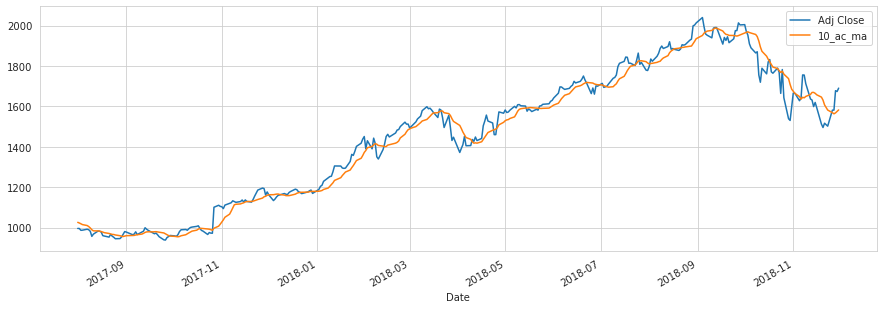

In [99]:
df_amzn[start_date:end_date][['Adj Close', '10_ac_ma']].plot(legend=True,figsize=(15,5))

#### Alphabet Inc. stock moving averages

In [100]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_googl[column_name] = moving_average(df_googl['Adj Close'], window_size=mds)
    df_googl_train[column_name] = moving_average(df_googl_train['Adj Close'], window_size=mds)
    df_googl_test[column_name] = moving_average(df_googl_test['Adj Close'], window_size=mds)
    df_googl_valid[column_name] = moving_average(df_googl_valid['Adj Close'], window_size=mds)

In [101]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [102]:
df_googl.fillna(method='backfill', inplace=True)

In [103]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987


In [104]:
df_googl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


In [105]:
df_googl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-07-02,1104.829956,1112.890015,1099.670044,1112.599976,1112.599976,1031500,NaN,NaN,NaN
2019-07-03,1118.500000,1127.989990,1114.849976,1122.989990,1122.989990,1007700,NaN,NaN,NaN
2019-07-05,1119.369995,1134.650024,1117.500000,1132.670044,1132.670044,1489700,NaN,NaN,NaN
2019-07-08,1125.869995,1127.209961,1111.760010,1116.790039,1116.790039,1494400,NaN,NaN,NaN
2019-07-09,1110.319946,1127.859985,1107.150024,1124.290039,1124.290039,1473600,NaN,NaN,NaN


In [106]:
df_googl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-10-23,1615.050049,1634.119995,1611.910034,1632.979980,1632.979980,1527400,NaN,NaN,NaN
2020-10-26,1615.000000,1629.579956,1567.780029,1584.290039,1584.290039,1791300,NaN,NaN,NaN
2020-10-27,1588.930054,1602.000000,1576.989990,1598.880005,1598.880005,1295100,NaN,NaN,NaN
2020-10-28,1550.010010,1553.810059,1508.479980,1510.800049,1510.800049,2258700,NaN,NaN,NaN
2020-10-29,1517.020020,1588.739990,1516.550049,1556.880005,1556.880005,2770300,NaN,NaN,NaN


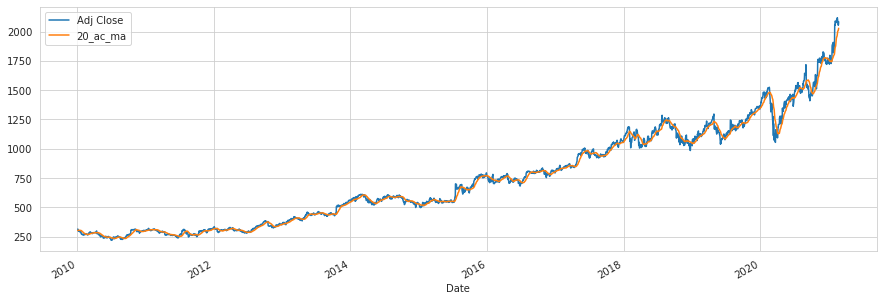

In [107]:
df_googl[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

### Metrics computation

Computing metrics on the benchmark model will give me a good reference to evaluate the deep learning model after training.

As can be presumed and seen from data prints, first `n` values of validation data are `NaN` so, it will be better just to exclude the first `n-1` values from the validation set to avoid misleading values to be catch in metrics evaluation. 

In [108]:
from sklearn.metrics import mean_squared_error

#### IBM stock

In [109]:
n = 10
ma_str = str(n)+'_ac_ma'

In [110]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid.iloc[n-1:][ma_str])

In [111]:
print(ibm_ma_mse_loss)

20.96714652276125


In [112]:
n = 20
ma_str = str(n)+'_ac_ma'

In [113]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [114]:
print(ibm_ma_mse_loss)

50.734211857741414


In [115]:
n = 50
ma_str = str(n)+'_ac_ma'

In [116]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [117]:
print(ibm_ma_mse_loss)

83.95766730826244


#### Apple Inc. stock

In [118]:
n = 10
ma_str = str(n)+'_ac_ma'

In [119]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid.iloc[n-1:][ma_str])

In [120]:
print(aapl_ma_mse_loss)

18.29865184299886


In [121]:
n = 20
ma_str = str(n)+'_ac_ma'

In [122]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid[n-1:][ma_str])

In [123]:
print(aapl_ma_mse_loss)

38.95931170013711


In [124]:
n = 50
ma_str = str(n)+'_ac_ma'

In [125]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid[n-1:][ma_str])

In [126]:
print(aapl_ma_mse_loss)

111.9809886416686


#### Amazon.com stock

In [127]:
n = 10
ma_str = str(n)+'_ac_ma'

In [128]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid.iloc[n-1:][ma_str])

In [129]:
print(amzn_ma_mse_loss)

6323.082422647271


In [130]:
n = 20
ma_str = str(n)+'_ac_ma'

In [131]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid[n-1:][ma_str])

In [132]:
print(amzn_ma_mse_loss)

7914.845676498657


In [133]:
n = 50
ma_str = str(n)+'_ac_ma'

In [134]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid[n-1:][ma_str])

In [135]:
print(amzn_ma_mse_loss)

5541.827626658253


#### Alphabet Inc. stock

In [136]:
n = 10
ma_str = str(n)+'_ac_ma'

In [137]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid.iloc[n-1:][ma_str])

In [138]:
print(googl_ma_mse_loss)

3454.253487663864


In [139]:
df_googl_valid.iloc[n-1:]['Adj Close']

Date
2020-11-05    1762.500000
2020-11-06    1759.729980
2020-11-09    1761.420044
2020-11-10    1737.719971
2020-11-11    1747.229980
                 ...     
2021-02-18    2105.810059
2021-02-19    2088.810059
2021-02-22    2054.260010
2021-02-23    2060.120117
2021-02-24    2083.810059
Name: Adj Close, Length: 75, dtype: float64

In [141]:
n = 20
ma_str = str(n)+'_ac_ma'

In [142]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid[n-1:][ma_str])

In [143]:
print(googl_ma_mse_loss)

7967.705614004688


In [144]:
n = 50
ma_str = str(n)+'_ac_ma'

In [145]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid[n-1:][ma_str])

In [146]:
print(googl_ma_mse_loss)

30730.152605109568


In [148]:
print(volatility(df_ibm_valid.iloc[n-1:]['Adj Close'], n))

18.366810172011967


In [149]:
print(volatility(df_aapl_valid.iloc[n-1:]['Adj Close'], n))

26.48063617102319


In [147]:
print(volatility(df_amzn_valid.iloc[n-1:]['Adj Close'], n))

1673.5543743084297


In [140]:
print(volatility(df_googl_valid.iloc[n-1:]['Adj Close'], n))

1838.1654532164541


As expected, loss augments as we observe moving average on larger windows.
Also, we can observe that Amazon.com and Alphabet Inc. have greater losses, that also corresponds to higher volatility.